This notebook demonstrates pre-processing steps of single-cell data in scanpy. This includes normalisation, feature selection through highly variable gene (HVG) identification, extracting meaningful variation from the dataset through PCA and KNN and clustering. 

In [1]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

In [2]:
alldata_batch = sc.read_h5ad('new_data/concatenated_data/alldata.h5ad')

/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [3]:
alldata_batch

AnnData object with n_obs × n_vars = 63530 × 18079
    obs: 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hsps', 'log1p_total_counts_hsps', 'pct_counts_hsps', 'total_counts_strs', 'log1p_total_counts_strs', 'pct_counts_strs', 'ribo_outlier', 'mito_outlier', 'n_counts', 'doublet_scores', 'predicted_doublets', 'sample', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

After QC steps the data comprises of a filtered cells x gene counts which are assumed to be genuine cells and functionally informative genes. The counts that a count matrix starts with are integer numbers representing RNA molecules. 
In this notebook it is highlighted the importance of normalisation prior to any other dimensionality reduction and analysis steps as a way to retrieve the true contribution of each gene to the gene expression distribution and remove any biases related to cell sequencing depth, very highly expressed genes or overdispersion. 

In [3]:
# The currently stored objects in Anndata_Objects do not have this layer so it is best to transfer it if using them
alldata_batch.layers['raw'] = alldata_batch.X.copy() # not saving to Anndata.raw since .raw is not sliced when Anndata is sliced and it keeps old .var and .obs index 
# which sometimes transfers to the current Anndata object after the current index has changed. 


It is the easiest to save the raw counts to a 'raw' layer as with slicing Anndata objects layers are sliced too. Therefore we can obtain 
easily a HVG version in raw counts

In [4]:
alldata_batch.layers['raw'].max()

1670.0

We save each normalisation step in a separate layer for clarity and for plotting of count distributions. 

In [5]:
# this is for library size normalisation (sequencing depth of every cell)
sc.pp.normalize_total(alldata_batch)
alldata_batch.layers['norm'] = alldata_batch.X.copy()

In [9]:
sc.pp.log1p(alldata_batch)
alldata_batch.layers['log1p_norm'] = alldata_batch.X.copy()

In [12]:
# the easiest way to check what kind of counts are stored in .X with a sparse matrix when it is hard to print large subsets of the 
# matrix itself
alldata_batch.X.max()

1670.0

In [7]:
labels_pr= {
    '2i': 'escs',
    'ESLIF': 'escs',
    'EB_8d': 'eb2',
    'EB_2d': 'eb1',
    'HD_8d': 'hd2',
    'HD_2d': 'hd1',
    'RA_7d': 'nora',
    'RA_0d': 'nora',
    '20_nM_RA': 'ras',
    '5000_nM_RA': 'ras'
}

alldata_batch.obs['batch'] = alldata_batch.obs['sample'].map(labels_pr)


Following that, feature selection aims to isolate these features that might be very informative about specific effects in our data due, for example, to an experimental condition. In addition, this also helps removing the influence of genes with very high dropout rates on the subsequently identified manifold. The genes that are considered more important for subsequent pre-processing steps and clustering are the highly variable genes (around 1000-3000 depending on the size of the dataset). HVGs are not necessarily also used for downstream analysis - they are important for denoising and isolating the signal in the data for clustering, but they are not the *only* informative genes in the dataset.
The HVG funtcions in scanpy can also model batch-driven variation as they can be used with batch_key= any .obs batch key in the data, to identify highly variable genes within each batch. This can represent a type of "soft" batch correction. 
However it is important to note that this method should be use only if other integration/batch-correction methods did not work or if this is simply the method of choice. If this algorithm is applied for batch correction prior to correction with another algorithm, this can dramatically drop the effectiveness of the second one.

We chose a Pearson residuals algorithm that works directly on the raw (negatively binomial) as it has been shown to more accurately identify as highly variable biologically interesting genes rather than genes which are simply highly expressed

In [8]:
    # PLOTTING CODE BLOCKS BY:
    # Heumos, L., Schaar, A.C., Lance, C. et al. Best practices for single-cell analysis across modalities. Nat Rev Genet 24, 550–572 (2023). 
    # DOI: https://doi.org/10.1038/s41576-023-00586-w
    # see "Single-cell best practices" book, openly available
def hvg_and_plot(alldata_batch, batch=None):
    '''
    
    Calculate highly variable genes in batch-aware or non-batch-aware manner, plot genes by residual variance, visualise HVGs within batches

    Args:
        alldata_batch (Anndata object): raw-counts Anndata object (containing all datasets)
        batch (str), default=None: the .obs column name which denotes batch in data
        
    Returns:
        None: it overwrites alldata_batch at calling
    '''
    sc.experimental.pp.highly_variable_genes(
        alldata_batch, n_top_genes=2500, flavor="pearson_residuals", batch_key=batch
    )
    fig = plt.figure(figsize=(3, 3))
    ax = plt.axes()
    hvgs = alldata_batch.var["highly_variable"]
    
    ax.scatter(
        alldata_batch.var["means"], alldata_batch.var["residual_variances"], s=3, edgecolor="none"
    )
    ax.scatter(
        alldata_batch.var["means"][hvgs],
        alldata_batch.var["residual_variances"][hvgs],
        c="tab:red",
        label="selected genes",
        s=3,
        edgecolor="none",
    )
    ax.set_xscale("log")
    ax.set_xlabel("mean expression")
    ax.set_yscale("log")
    ax.set_ylabel("residual variance")
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.set_ticks_position("left")
    ax.xaxis.set_ticks_position("bottom")
    plt.title('Highly Variable Genes', weight='bold', fontsize=12)
    plt.savefig('HVG.png', dpi=300, bbox_inches='tight')
    plt.show()
    if batch is not None:
        n_batches = alldata_batch.var["highly_variable_nbatches"].value_counts()
        ax = n_batches.plot(kind="bar")
        ax.set_xlabel("Number of Batches")
        ax.set_ylabel("Gene Count")
        ax.set_title("Highly Variable Genes per Batch", weight='bold', fontsize=12)
        plt.savefig('batch_distribution.png', dpi=300, bbox_inches='tight')
        plt.show()

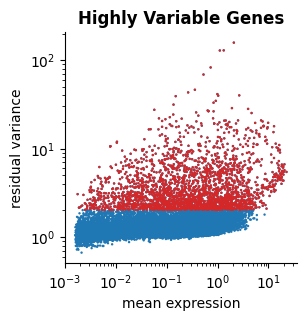

In [10]:
alldata_batch.X=alldata_batch.layers['raw']
hvg_and_plot(alldata_batch)

In our case we performed HVG with batch_key=None and relied on other integration methods to correct for the batch effects. However, we still processed a version of the data with batch_key activated in order to see how it affects separation of clusters. WIth our current QC and proeprocessing pipeline, the batch-aware HVG did not have substantial effects on clustering.

Here it is imperative to create a copy of the Anndata object with all genes as these genes are used subsequently for DE analysis and enrichment. This object will be supplied with all the slots that store UMAP embeddings and clustering.

In [17]:
alldata_full=alldata_batch.copy()
alldata_batch.X = alldata_batch.layers['log1p_norm'].copy()
alldata_batch = alldata_batch[:, alldata_batch.var["highly_variable"]].copy() # subsetting the object to only HVGs

/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


This is a function which makes barplots to visualise the count distribution at each normalisation step.

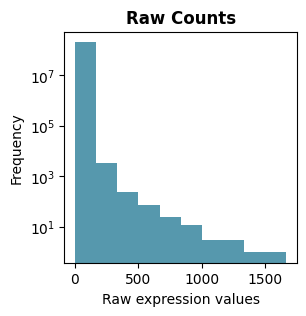

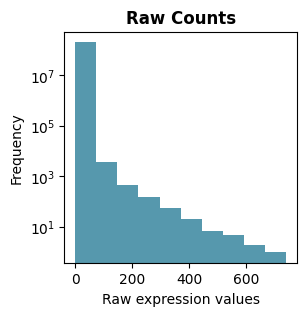

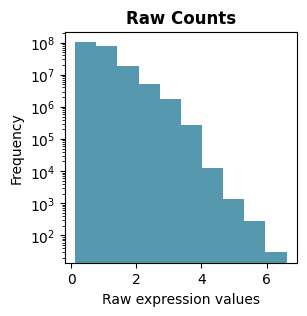

In [13]:
def check_count_distr(alldata_batch):
    '''
    'Plot histograms of counts in .X for every layer to see if the counts are correct and if the normalisation steps went through

    Args:
        alldata_batch (Anndata object): Anndata object (containing all datasets) with normalised .X versions stored in .layers
        
    Returns:
        None
    '''
    for layer in alldata_batch.layers:
        alldata_batch.X=alldata_batch.layers[layer].copy()
        counts = alldata_batch.X.data #extract only relevant data from a sparse matrix

        # plot frequency of particular UMI count quantities (UMI count distribution)
        plt.figure(figsize=(3, 3))
        plt.hist(counts, bins=10, color='#0E6C8A', alpha=0.7) 
        plt.xlabel("Expression values")
        # plt.xlim(-5, 10)
        plt.ylabel("Frequency")
        if layer== 'norm':
            plt.title("Log-normalised Counts", weight='bold', fontsize=12)
        elif layer =='log1p_norm':
            plt.title("Size-normalised Counts", weight='bold', fontsize=12)
        else:
            plt.title("Raw Counts", weight='bold', fontsize=12)
        plt.yscale("log")
        plt.savefig('histo_raw.png', dpi=300, bbox_inches='tight')
        plt.show()

Scaling is a step that is routinely performed before PCA to make the counts have zero mean and unit variance in order to make the genes have equal contributions to the overall variance which is an additional step to make PCA more reliable.

In [25]:
sc.pp.scale(alldata_batch)
alldata_batch.layers['scaled'] = alldata_batch.X.copy()

In [26]:
alldata_batch

AnnData object with n_obs × n_vars = 63530 × 18079
    obs: 'total_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mito', 'log1p_total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hsps', 'log1p_total_counts_hsps', 'pct_counts_hsps', 'total_counts_strs', 'log1p_total_counts_strs', 'pct_counts_strs', 'ribo_outlier', 'mito_outlier', 'n_counts', 'doublet_scores', 'predicted_doublets', 'sample', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_name', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: 'log1p', 'hvg'
    layers: 'scaled'

Then the data is dimensionally reduced with PCA in order to remove the effects of intrinsic feature correlations and redundancy on the signal identification in the data. The following function also contains options to plot confounding covariates on the PCA embedding in order to see if they have strong effects on the top PCs determination.

In [27]:
def pca(alldata_batch, covs, dims,filename,first=True):
    '''
    Calculate PCA, plot variance contributions of PCs, choose PCs amount, plot how data covariates (such as quality metrics) vary with top PCs and visualise
    on PCA embedding

    Args:
        alldata_batch (Anndata object): log-normalised Anndata object (containing all datasets) with .X set as log-normalised counts
        covs (list): list of strings, covariates to plot on PCA embedding. 
        dims (list): list of tuples, each tuple of two int values, designating PC number
        filename (str): filename with extension for saving multiple covariate embedding files
        first (bool), default=True: whether to calculate PCA and PC variance ratio or are they already available.
        
    Returns:
        None: it overwrites alldata_batch at calling
    '''
    if first: # calcluate pca and visualise PC variance ratio if still not calculated
        sc.tl.pca(alldata_batch, n_comps=50) 
        plt.figure(figsize=(4,3))
        p=sc.pl.pca_variance_ratio(alldata_batch, n_pcs=50, show=False)
        plt.title('PCA Variance Ratio', weight='bold', fontsize=12)
        plt.savefig('pca_var.png', dpi=300, bbox_inches='tight')
    sc.pl.pca(
        alldata_batch,
        color=covs,
        dimensions=dims,
        ncols=2,
        size=2
    )
    plt.savefig(filename, dpi=300)
    plt.show()

The KNN algorithm in scanpy creates a neighborhood graph which connects similar cells and identifies dense areas of cells which then facilitates Leiden clustering.

In [27]:
sc.pp.neighbors(alldata_batch, n_neighbors=30, use_rep='X_pca', n_pcs=20)

/net/virus/linuxhome/vivek-group/maria/virtual/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-03 23:46:45.873080: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751579205.915495 2331176 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751579205.928523 2331176 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1751579205.954217 2331176 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same targ

UMAP, as a non-linear dimensionality reduction technique is effective for single-cell data to produce a 2D representation of the data and visualise clustering.

In [28]:
sc.tl.umap(alldata_batch)

Different resolutions in Leiden clustering can be tested which helps with the identification of possible subtle changes in cell states and subclusters but also can produce noise-driven patterns.

In [29]:
for r in [0.25, 0.5, 1]:  
    sc.tl.leiden(alldata_batch, key_added=f"leiden_res{str(r)}", resolution=r) # memory-intensive step

/tmp/ipykernel_2331176/1062310390.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(alldata_batch, key_added=f"leiden_res{r}", resolution=float(r))


With this function UMAP embeddings of the different resolutions can easily be plotted, and this is also useful when comparing different prior-preprocessing pipelines.

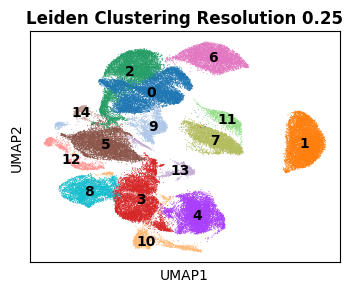

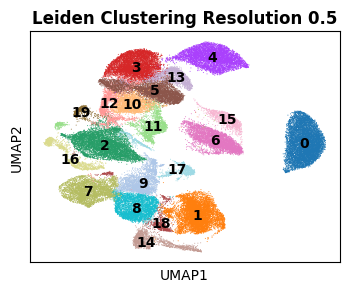

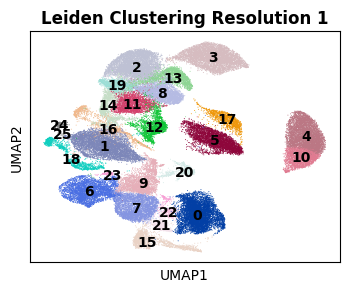

In [30]:
def plot_embedding(alldata_batch, res, label):
    '''
    Plot UMAP embeddings of different resolutions. This supports any clustering algorithm which saves resolutions of clustering in .obs

    Args:
        alldata_batch (Anndata object): Anndata object (containing all datasets) with clustering resolutions stored in .obs
        res (list): list of str, for different clustering resolutions
        label (str): the clustering label for .obs clustering column name that the user provided at the clustering step, e.g. "leiden_res".
        
    Returns:
        None: it overwrites alldata_batch at calling
    '''
    res=['0.25','0.5', '1']
    for i in range(len(res)):
        fig, ax = plt.subplots(figsize=(4,3))
        sc.pl.umap(alldata_batch, color=[f"{label}{res[i]}"], show=False, ax=ax, legend_loc='on data')
        ax.set_title(f'Clustering Resolution {res[i]}', fontsize=12, weight='bold')
        plt.savefig(f'clustering_{res[i]}.png', dpi=300, bbox_inches='tight')
        plt.show()
plot_embedding(alldata_batch)

We always need to keep the raw counts around, not only since some tools such as DE or integration tools may require raw counts but also because in some cases raw counts are more informative about the real state of expressed genes.
Then we make sure to transfer all information gained with dimensinality reduction and clustering to the full (non-HVG) object.

In [ ]:
# transfer key estimations to the full object, but this was not done at the time of analysis prior to saving the objects
# obsm=alldata_batch.obsm.copy()
# uns=alldata_batch.uns.copy()
# varm=alldata_batch.varm.copy()
# obsp = alldata_batch.obsp.copy()
# clustering=alldata_batch.obs['leiden_res0.5'].copy()
# alldata_full.obsm=obsm
# alldata_full.uns=uns
# alldata_full.obsp=obsp
# alldata_full.obs['leiden_res0.5']=clustering

In [98]:
alldata_batch.X = alldata_batch.layers['raw']
alldata_batch.write_h5ad(f'new_data/umap/alldata_batch.h5ad', compression='gzip') #save with raw counts in .X, HVG object

In [99]:
alldata_full.X=alldata_full.layers['raw']
alldata_full.write_h5ad(f'new_data/umap/alldata.h5ad', compression='gzip') #object with all genes in raw counts

References:
1. Heumos, L., Schaar, A.C., Lance, C. et al. Best practices for single-cell analysis across modalities. Nat Rev Genet 24, 550–572 (2023). https://doi.org/10.1038/s41576-023-00586-w
2. see https://nbisweden.github.io/workshop-archive/workshop-scRNAseq/2020-01-27/labs/compiled/scanpy/scanpy_02_dim_reduction.html for a tutorial on dimensionality reduction and visualising covariates on the PCA embedding
3. Lause, J., Berens, P. & Kobak, D. Analytic Pearson residuals for normalization of single-cell RNA-seq UMI data. Genome Biol 22, 258 (2021). https://doi.org/10.1186/s13059-021-02451-7